# Fernandes and Artemieva (2012) LPSC abstract

Modeled Imbrium impact shock, ejecta temps vs distance for "ancient-cold-moon" and "present-hot-moon".

Fig 4 shows thickness and temp vs distance for a 100 km diameter impactor.

Imbrium assumed to have a 769 km transient crater diameter

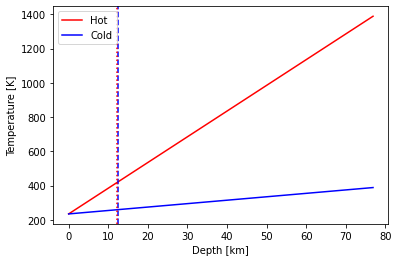

In [2]:
import numpy as np
import matplotlib.pyplot as plt
diam = 769  # [km]
T0 = 235  # [K]
T0_cold = 260#210  # [K]  Fig 4. proximal, cold
T0_hot = 420#290  # [K]  Fig 4. proximal, hot
dt_hot = 15  # [K/km]
dt_cold = 2  # [K/km]
depth = np.linspace(0, diam/10, 1000)
T_hot = T0 + dt_hot * depth
T_cold = T0 + dt_cold * depth
plt.plot(depth, T_hot, 'r', label='Hot')
plt.plot(depth, T_cold, 'b', label='Cold')

d_cold = depth[np.argmin(np.abs(T_cold - T0_cold))]
d_hot = depth[np.argmin(np.abs(T_hot - T0_hot))]
plt.axvline(d_cold, color='b', linestyle='--')
plt.axvline(d_hot, color='r', linestyle=':')
plt.xlabel('Depth [km]')
plt.ylabel('Temperature [K]')
plt.legend()

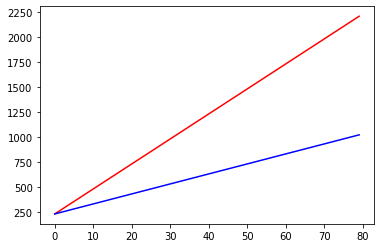

In [5]:
depth = np.arange(80)
dt_hot = 25 # [K/km]
dt_cold = 10 # [K/km]
T_hot = T0 + dt_hot * depth
T_cold = T0 + dt_cold * depth
plt.plot(depth, T_hot, 'r', label='Hot')
plt.plot(depth, T_cold, 'b', label='Cold')

basin_ejecta_temp_params_cold: [ 2.032e+06 -7.658e+03  2.520e+02]
basin_ejecta_temp_params_warm: [ 2.449e+06 -2.384e+04  4.762e+02]


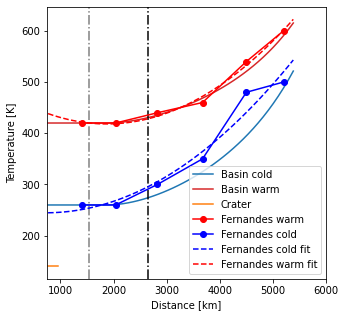

In [4]:
from moonpies import moonpies as mp
from moonpies import config
cfg = config.Cfg()

fig, ax = plt.subplots(figsize=(5, 5))
df = mp.get_crater_basin_list()

d_imb = 769*1e3 # [m] Imbrium, basin diam used in Fernandes and Artemieva
d_crater = df[~df.isbasin].diam.max()  # [m] largest non-basin crater
d_basin_max = df[df.isbasin].diam.max()  # [m] largest basin

dist = np.linspace(d_imb, d_imb*7)
for diam, label in zip((d_imb, d_crater), ('Imbrium', 'Crater')):    
    dist_crad = dist / (diam/2)
    thick = mp.get_ejecta_thickness(dist.reshape(1, -1), np.atleast_1d(diam/2), cfg).squeeze()
    mass = thick * cfg.target_density  # [kg/m^2]
    vel = mp.ballistic_velocity(dist, cfg)

    # Use only kinetic energy in excess of ke_heat_frac_speed
    v_excess = vel - cfg.ke_heat_frac_speed
    v_excess[v_excess < 0] = 0

    # Get KE and scale by fraction converted to heat
    heat_frac = cfg.ke_heat_frac
    ke = heat_frac * mp.kinetic_energy(mass, v_excess)

    # Get temps and plot
    x = dist.squeeze() / 1e3  # [km]
    if label == 'Crater':
        t0_c = cfg.polar_ejecta_temp_init
        dt_c = mp.delta_t_impact(ke, mass, mp.specific_heat_capacity(t0_c, cfg))
        t_dist = t0_c + dt_c
        end = np.argmin(np.abs(dist_crad - 20))  # 10 crater radii
        ax.plot(x[:end], t_dist[:end], '-', c='tab:orange', label='Crater')
    else:
        t0_cold = cfg.basin_ejecta_temp_init_cold
        t0_warm = cfg.basin_ejecta_temp_init_warm    
        dt_cold = mp.delta_t_impact(ke, mass, mp.specific_heat_capacity(t0_cold, cfg))
        dt_warm = mp.delta_t_impact(ke, mass, mp.specific_heat_capacity(t0_warm, cfg))
        t_dist_cold = t0_cold + dt_cold
        t_dist_warm = t0_warm + dt_warm
        ax.plot(x, t_dist_cold, '-', c='tab:blue', label='Basin cold')
        ax.plot(x, t_dist_warm, '-', c='tab:red', label='Basin warm')
        
ax.axvline(4*d_imb / 2e3, c='gray', ls='-.')
ax.axvline(4*d_basin_max / 2e3, c='k', ls='-.')
ax.set_xlabel('Distance [km]')
ax.set_ylabel('Temperature [K]')
ax.set_xlim(750, 6000)
# ax.set_ylim(140, 600)

# Points for Imbrium from Fig. 4, Fernandes and Artemieva (2012)
fernandes_dist = np.array([1400, 2040, 2825, 3675, 4500, 5200])
fernandes_cold = np.array([260, 260, 300, 350, 480, 500])
fernandes_warm = np.array([420, 420, 440, 460, 540, 600])
ax.plot(fernandes_dist, fernandes_warm, 'ro-', label='Fernandes warm')
ax.plot(fernandes_dist, fernandes_cold, 'bo-', label='Fernandes cold')

# Fit to Fernandes and Artemieva (2012)
crad = fernandes_dist / (d_imb/2)
xrad = x / (d_imb/2)
pcb, pca = np.polyfit(fernandes_dist, np.log(fernandes_cold), 1)
# ax.plot(x, np.exp(pca+xrad*pcb), 'b--', label='Fernandes cold fit')

pcold = np.polyfit(crad, fernandes_cold, 2)
fcold = np.poly1d(pcold)
ax.plot(x, fcold(xrad), 'b--', label='Fernandes cold fit')
print(f'basin_ejecta_temp_params_cold: {np.array2string(pcold, precision=3)}')

pwarm = np.polyfit(crad, fernandes_warm, 2)
fwarm = np.poly1d(pwarm)
ax.plot(x, fwarm(xrad), 'r--', label='Fernandes warm fit')
print(f'basin_ejecta_temp_params_warm: {np.array2string(pwarm, precision=3)}')

# axb = ax.twinx()
# axb.plot(x, thick, 'k--', label='Ejecta thickness')
# axb.set_ylabel('Ejecta thickness [m]')
# axb.set_ylim(100, 500)
ax.legend()
plt.show()